#### Find the index at which the utterance begins and ends

In [869]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../../')
import IPython.display as ipd
import librosa
import numpy as np
from torch.utils.data import DataLoader
from tts.WaveRNN.wavernn import WaveRNN, combine_signal
from tts.WaveRNN.dataset import WaveRNNDataset, normalize, split_signal
from mlutils.utils import plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [870]:
dataset = WaveRNNDataset(with_conditions=False, remove_silence=False)
loader = DataLoader(
    dataset, batch_size=1, shuffle=False, collate_fn=dataset.collate_fn, drop_last=False, num_workers=1)

In [871]:
for i, d in enumerate(loader):
    raw = d
    c = d[0].squeeze().numpy()
    f = d[1].squeeze().numpy()
    wav = combine_signal(d[0].squeeze().numpy(), d[1].squeeze().numpy())
    if i == 0: break

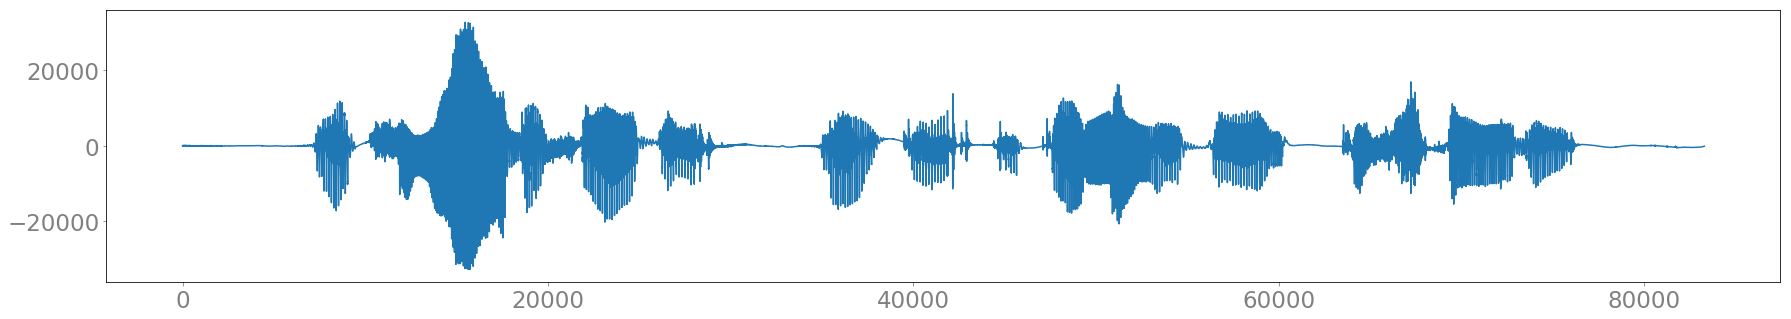

In [872]:
plot(wav)
ipd.Audio(wav, rate=24000)

In [873]:
c[:100]

array([128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 127., 127., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 127., 127., 127., 128., 128., 128., 128.,
       128., 128., 128., 128., 127., 127., 127., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128., 128., 128., 128., 128., 128., 128., 128., 128., 128., 128.,
       128.], dtype=float32)

In [874]:
s, e, r = 0, len(c), 8
for x in c:
    if not (x in range(128-r, 128+r)): break
    s += 1
for x in reversed(c):
    if not (x in range(128-r, 128+r)): break
    e -= 1
print(f'start {s} end {e}')

start 7297 end 76064


In [875]:
c[s]

136.0

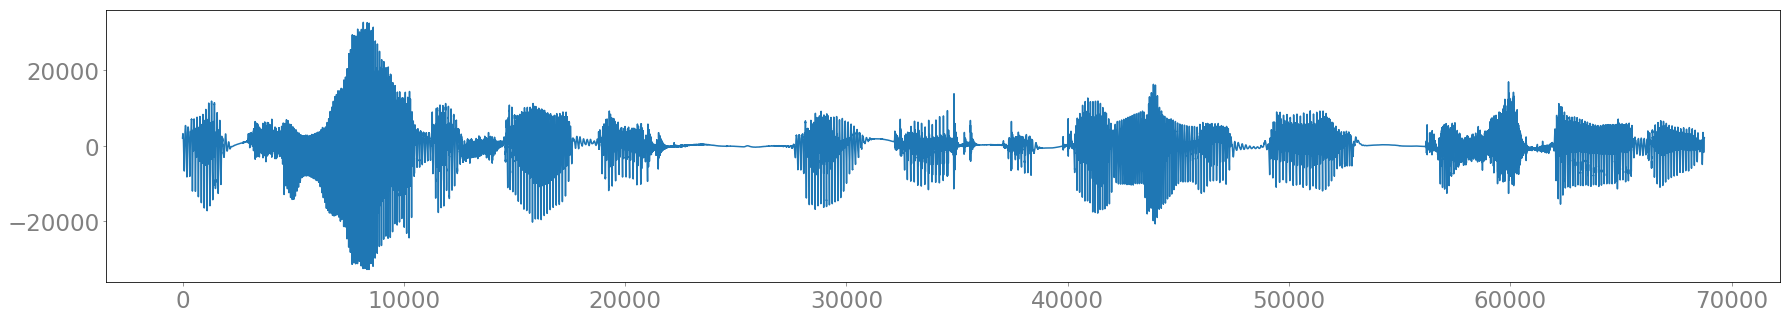

In [876]:
plot(wav[s:e])
ipd.Audio(wav, rate=24000)

improvement version (remove all silences)

In [877]:
def remove_silence(wav, r=8, s=3000):
    """Remove silence from wav.
    
    args:
        wav (ndarray):
        r (int): range to be considered as silence (8 bit normalized) 
        s (int): min trim size
    """
    def is_valid(x, r=8):
        return not (x in range(128-r, 128+r))
    def remove_last(x, l):
        return x[:len(x)-l]

    valid_c = []
    valid_f = []
    silence_indices = []
    min_trim_size = s
    wav_len = len(wav)
    assert isinstance(wav, np.ndarray), 'input must be type of ndarray.'
    c, f = split_signal(normalize(wav), from_bit=16, to_bit=8)
    for i, (c, f) in enumerate(zip(c, f)):
        valid_c.append(c)
        valid_f.append(f)
        if not is_valid(c):
            silence_indices.append(i)
        elif len(silence_indices) > min_trim_size:
            print(f'long silence detected. tash last {len(silence_indices)} samples.')
            valid_c = remove_last(valid_c, len(silence_indices))
            valid_f = remove_last(valid_f, len(silence_indices))
            silence_indices = []
        else:
            silence_indices = []
        if i == wav_len-1 and len(silence_indices):
            print(f'trim last {len(silence_indices)} silent samples.')
            valid_c = remove_last(valid_c, len(silence_indices))
            valid_f = remove_last(valid_f, len(silence_indices))
    return combine_signal(np.array(valid_c), np.array(valid_f))

In [878]:
new_wav = remove_silence(np.array(wav))
len(new_wav)

long silence detected. tash last 7297 samples.
long silence detected. tash last 6091 samples.
long silence detected. tash last 3206 samples.
trim last 7215 silent samples.


59470

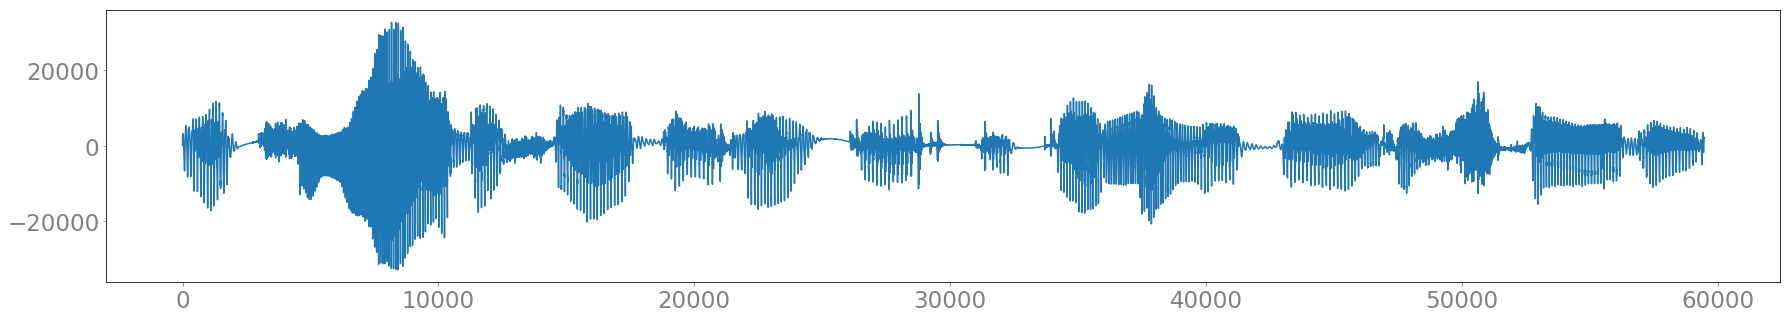

In [879]:
plot(new_wav)

In [891]:
from tools.libaudio.utils import remove_silence
new_wav = remove_silence(wav)

long silence detected. tash last 7297 samples.
long silence detected. tash last 6091 samples.
long silence detected. tash last 3206 samples.
trim last 7215 silent samples.


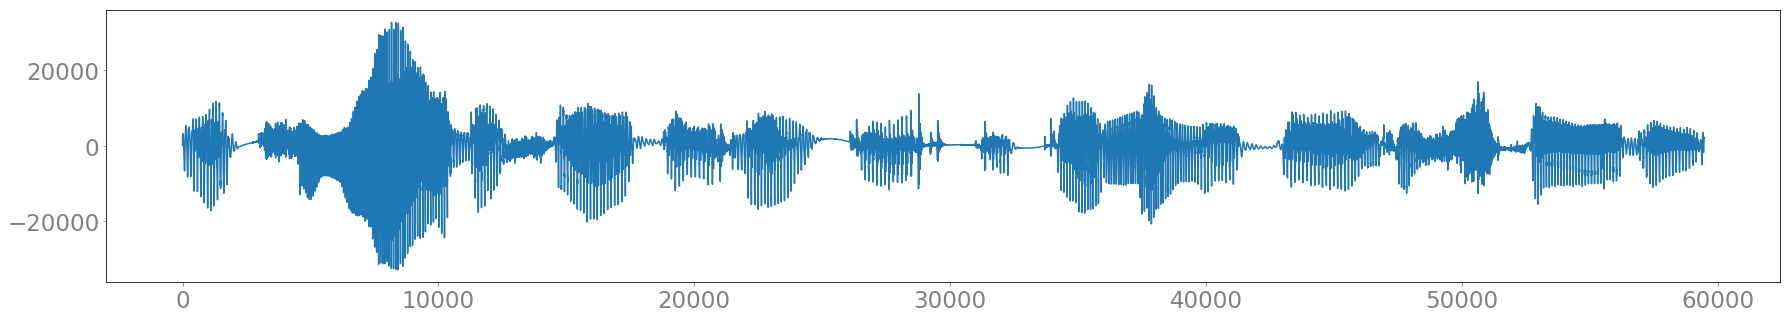

In [893]:
plot(new_wav)

In [892]:
ipd.Audio(new_wav, rate=24000)

librosa trim (not good)

In [881]:
loader = DataLoader(
    dataset, batch_size=1, shuffle=False, drop_last=False, num_workers=1)
for d in loader:
    raw = d
    break

In [882]:
raw['wav']

tensor([[ 0.0007,  0.0008,  0.0003,  ..., -0.0011, -0.0010, -0.0011]])

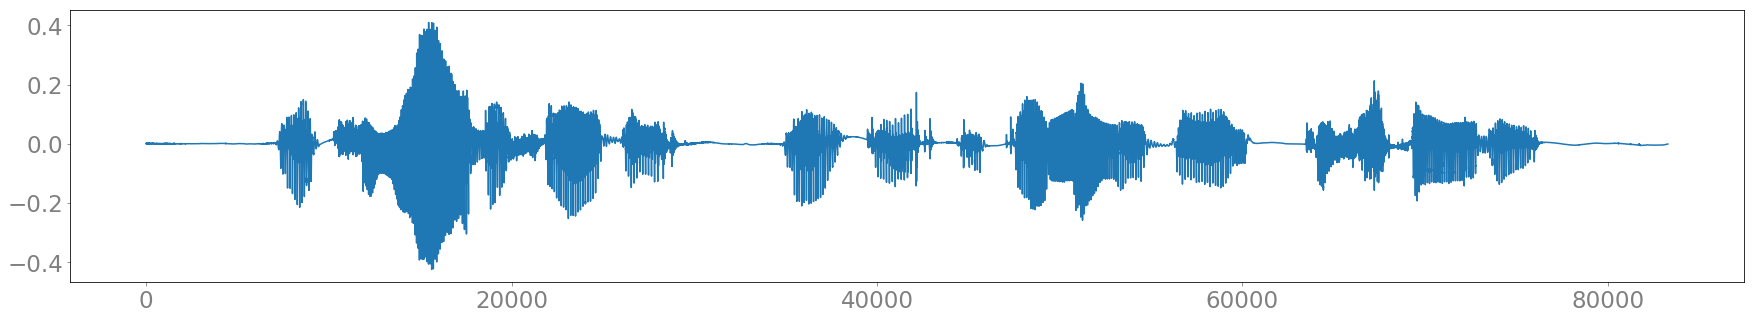

In [883]:
plot(raw['wav'][0])

In [884]:
trimmed, indice = librosa.effects.trim(raw['wav'][0].numpy(), top_db=6)

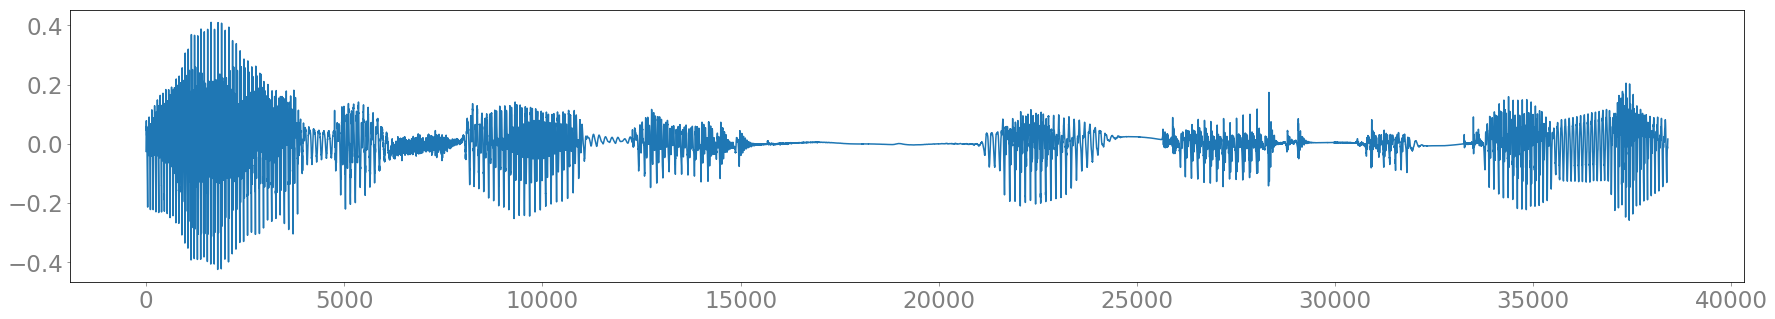

In [885]:
plot(trimmed)

In [886]:
ipd.Audio(trimmed, rate=24000)